# About
This was used to produce Figure 4.

# Prereqs

In [1]:
import collections
import csv
import gzip
import pathlib
import sys
import time

In [2]:
from matplotlib import pyplot

In [3]:
sys.path.append('/galaxy/home/nick/code/nick-bfx')
import fastagenerators

In [4]:
%matplotlib inline

In [5]:
MAIN_DIR = pathlib.Path('/nfs/brubeck.bx.psu.edu/scratch5/nick/overlaps/auto/ecoli')
CSV_PATH = MAIN_DIR/'sra.runinfo3.csv.gz'
# The reference most frequently chosen as the best match for each run
REF_PATH = MAIN_DIR/'refs/individual/GCF_008761455.1_ASM876145v1_genomic.fna'
COLORS = collections.OrderedDict((('A','#3ab53a'), ('T','#d24343'), ('C','#3491d1'), ('G','#f68b2b')))
BASES = tuple(COLORS.keys())

## Reading metadata

In [6]:
def read_runinfo(csv_path):
  start = time.perf_counter()
  int_fields = {'spots', 'spots_with_mates', 'avgLength', 'size_MB', 'InsertSize', 'InsertDev', 'ProjectID', 'TaxID'}
  runs = {}
  header = {}
  empty_lines = 0
  header_lines = 0
  try:
    with gzip.open(csv_path, 'rt') as csv_file:
      for row in csv.reader(csv_file):
        if not header:
          header_lines += 1
          for i, value in enumerate(row):
            header[i] = value
          RunInfo = collections.namedtuple('RunInfo', header.values())
          continue
        if len(row) == 0:
          empty_lines += 1
          continue
        assert len(row) == len(header), (len(row), row)
        header_matches = 0
        value_dict = {}
        for i, raw_value in enumerate(row):
          if raw_value == header[i]:
            header_matches += 1
          else:
            if header[i] in int_fields:
              try:
                value = int(raw_value)
              except ValueError:
                if header[i] == 'InsertDev':
                  value = float(raw_value)
                else:
                  print(f'{header[i]}: {raw_value!r}', file=sys.stderr)
            else:
              value = raw_value
          value_dict[header[i]] = value
        if header_matches > 5:
          header_lines += 1
          continue
        runs[value_dict['Run']] = RunInfo(**value_dict)
  except EOFError:
    print('Incomplete gzip.', file=sys.stderr)
  elapsed = time.perf_counter() - start
  print(f'{len(runs)} runs in {elapsed:0.1f} seconds (headers: {header_lines}, empty lines: {empty_lines})')
  return runs

## Read in the metadata

In [7]:
RUNS = read_runinfo(CSV_PATH)

186022 runs in 13.2 seconds (headers: 1, empty lines: 0)


## Misc

In [8]:
def human_time(sec):
  if sec < 60:
    return format_time(sec, 'second')
  elif sec < 60*60:
    return format_time(sec/60, 'minute')
  elif sec < 24*60*60:
    return format_time(sec/60/60, 'hour')
  elif sec < 10*24*60*60:
    return format_time(sec/60/60/24, 'day')
  elif sec < 40*24*60*60:
    return format_time(sec/60/60/24/7, 'week')
  elif sec < 365*24*60*60:
    return format_time(sec/60/60/24/30.5, 'month')
  else:
    return format_time(sec/60/60/24/365, 'year')
def format_time(quantity, unit):
  rounded = round(quantity, 1)
  if rounded == int(quantity):
    rounded = int(quantity)
  output = str(rounded)+' '+unit
  if rounded != 1:
    output += 's'
  return output

In [9]:
def get_median(values):
  sorted_values = sorted(values)
  length = len(values)
  if length % 2 == 1:
    return sorted_values[length//2]
  else:
    left = sorted_values[length//2-1]
    right = sorted_values[length//2]
    return (left+right)/2

In [10]:
def rm_prefix(string, prefix):
  if string.startswith(prefix):
    return string[len(prefix):]
  else:
    return string

In [11]:
def matches_platform(runs, sample, platform):
  run = runs.get(sample)
  if not run:
    return False
  if platform == run.Model:
    return True
  abbrev = ' '.join(run.Model.split()[1:])
  if platform == abbrev:
    return True
  return False

In [12]:
def get_done_samples(done_file='seq-context.tsv', platform=None, runs=None, main_dir=MAIN_DIR):
  kmers = collections.Counter()
  start = time.time()
  num_done = 0
  for sample_dir in (main_dir/'runs').iterdir():
    sample = sample_dir.name
    context_path = sample_dir/done_file
    if not context_path.is_file():
      continue
    if (platform and runs) and not matches_platform(runs, sample, platform):
      continue
    yield sample

In [13]:
def group_samples_by_model(samples, runs=RUNS):
  samples_by_model = {}
  for sample in samples:
    run = runs[sample]
    model = rm_prefix(run.Model, 'Illumina ')
    try:
      samples_by_model[model].append(sample)
    except KeyError:
      samples_by_model[model] = [sample]
  return samples_by_model

## Analyzing the reference

In [14]:
def get_seq_kmers(ref_path, k):
  kmers = collections.Counter()
  for sequence in fastagenerators.FastaLineBuffered(ref_path):
    kmer = ''
    for base in sequence.bases():
      if len(kmer) == k:
        kmer = kmer[1:]+base
      elif len(kmer) < k:
        kmer += base
      else:
        raise AssertionError(f'kmer {kmer!r} longer than k ({k})')
      kmers[kmer] += 1
  kmer_list = list(kmers.keys())
  for kmer in kmer_list:
    if len(kmer) != k:
      del kmers[kmer]
  return kmers

## Analyze the reference

In [15]:
REF_KMERS = get_seq_kmers(REF_PATH, 3)

## Read in data

In [16]:
class Context(collections.namedtuple('Context', ('chr', 'pos', 'index', 'base', 'seq', 'gc'))):
  __slots__ = ()
  def __str__(self):
    output = []
    for i, base in enumerate(self.seq):
      if i == self.index:
        output.append('|'+base+'|')
      else:
        output.append(base)
    return ''.join(output)
  def __eq__(self, other):
    for field in self._fields:
      if getattr(self, attr) != getattr(other, attr):
        return False
    return True

In [17]:
def read_contexts(context_path):
  with context_path.open() as context_file:
    for line_raw in context_file:
      fields = line_raw.rstrip('\r\n').split('\t')
      if len(fields) != 6:
        continue
      if fields[5] == '.':
        gc = None
      else:
        gc = float(fields[5])
      yield Context(
        chr=fields[0],
        pos=int(fields[1]),
        index=int(fields[2]),
        base=fields[3],
        seq=fields[4],
        gc=gc,
      )

In [18]:
def dedup_contexts(contexts):
  done = set()
  for context in contexts:
    key = (context.chr, context.pos)
    if key not in done:
      yield context
      done.add(key)

In [19]:
def get_kmer_counts(samples, k, offset=1, dedup=True, main_dir=MAIN_DIR):
  """`offset` controls where the kmer is from relative to the error.
  It will be the (1-based) position of the error base in the kmer.
  So if `k` is 3 and `offset` is 1, then in the kmer `GAT`, `G` is the error position.
  If `offset` is 3, then `T` would be at the error.
  `offset` can be > `k` or < 1, in which case the kmer will be from before or after the error, respectively."""
  kmers = collections.Counter()
  start_time = time.perf_counter()
  num_done = 0
  for sample in samples:
    context_path = MAIN_DIR/'runs'/sample/'seq-context.tsv'
    context_generator = read_contexts(context_path)
    if dedup:
      context_generator = dedup_contexts(context_generator)
    for context in context_generator:
      start = context.index - offset + 1
      end = start + k
      kmer = context.seq[start:end].upper()
      if len(kmer) == k:
        kmers[kmer] += 1
    num_done += 1
  elapsed = int(time.perf_counter() - start_time)
  print(f'{num_done} samples in {human_time(elapsed)}')
  return kmers

In [20]:
samples_by_model = group_samples_by_model(get_done_samples(done_file='seq-context.tsv'))

In [21]:
MODELS = ('MiSeq', 'MiniSeq', 'NextSeq 500', 'NextSeq 550', 'HiSeq 2500', 'NovaSeq 6000', 'HiSeq X Ten')

In [22]:
kmers_by_model3 = {}
start = time.perf_counter()
for model in MODELS:
  print(f'Processing {model}')
  samples = samples_by_model[model]
  kmers_by_model3[model] = get_kmer_counts(samples, 3, offset=3)
elapsed = time.perf_counter() - start
print(f'Total: {human_time(elapsed)}')

Processing MiSeq
299 samples in 1.2 hours
Processing MiniSeq
69 samples in 17.6 minutes
Processing NextSeq 500
267 samples in 35.3 minutes
Processing NextSeq 550
282 samples in 1.1 hours
Processing HiSeq 2500
273 samples in 21.6 minutes
Processing NovaSeq 6000
346 samples in 38.9 minutes
Processing HiSeq X Ten
295 samples in 25.4 minutes
Total: 4.6 hours


In [29]:
def has_ambiguities(seq):
  for base in seq:
    if base not in 'ACGT':
      return True
  return False

In [30]:
def get_kmer_freqs(kmer_counts, canonical_only=True):
  kmer_freqs = {}
  kmers = []
  for kmer in kmer_counts.keys():
    if canonical_only:
      if has_ambiguities(kmer):
        continue
    kmers.append(kmer)
  total_count = sum([kmer_counts[kmer] for kmer in kmers])
  for kmer in kmers:
    kmer_freqs[kmer] = kmer_counts[kmer]/total_count
  return kmer_freqs

In [25]:
def get_normalized_freqs(kmers_by_model, ref_kmers):
  freqs_by_model = {}
  ref_freqs = get_kmer_freqs(ref_kmers)
  for model, kmer_counts in kmers_by_model.items():
    rel_freqs = {}
    kmer_freqs = get_kmer_freqs(kmer_counts)
    for kmer, freq in kmer_freqs.items():
      rel_freqs[kmer] = freq/ref_freqs[kmer]
    freqs_by_model[model] = rel_freqs
  return freqs_by_model

In [26]:
def get_medians(kmer_stats_by_model):
  medians = {}
  # Get superset of all (valid) kmers seen in all models.
  kmers = set()
  for model, kmer_stats in kmer_stats_by_model.items():
    model_kmers = [kmer for kmer in kmer_stats.keys() if not has_ambiguities(kmer)]
    if len(model_kmers) != 64:
      print(f'Warning: Got {len(model_kmers)} kmers for model {model}.')
    kmers = kmers | set(model_kmers)
  if len(kmers) != 64:
    print(f'Warning: Ended up with {len(kmers)} total kmers.')
  # Calculate medians.
  for kmer in kmers:
    stats = []
    for model, kmer_stats in kmer_stats_by_model.items():
      stats.append(kmer_stats[kmer])
    medians[kmer] = get_median(stats)
  return medians

In [27]:
def make_kmer_plot(kmers_by_model, ref_kmers, labels=None, limit=10):
  # Normalize kmer counts by genomic abundance.
  freqs_by_model = get_normalized_freqs(kmers_by_model, ref_kmers)
  # Sort the kmers by the median frequencies.
  medians = get_medians(freqs_by_model)
  kmers = sorted(medians.keys(), reverse=True, key=lambda kmer: medians[kmer])
  if labels is None:
    labels = sorted(freqs_by_model.keys())
  figure = pyplot.figure(dpi=120, figsize=(6,4.5))
  axes = figure.add_subplot(1,1,1)
  points_list = []
  x_vals = list(range(limit))
  y_vals = []
  for label in labels:
    freqs_by_kmer = freqs_by_model[label]
    freqs = []
    for kmer in kmers[:limit]:
      freq = freqs_by_kmer[kmer]
      freqs.append(freq)
    points = axes.scatter(x_vals, freqs, s=16)
    points_list.append(points)
  axes.set_xticks(x_vals)
  axes.set_xticklabels(kmers[:limit])
  axes.legend(points_list, labels, fontsize=8)
  axes.set_title('Representation of Trimers at Error Sites')
  axes.set_ylabel('Normalized Trimer Frequency')
  axes.set_xlabel(f'Top {limit} Trimers')

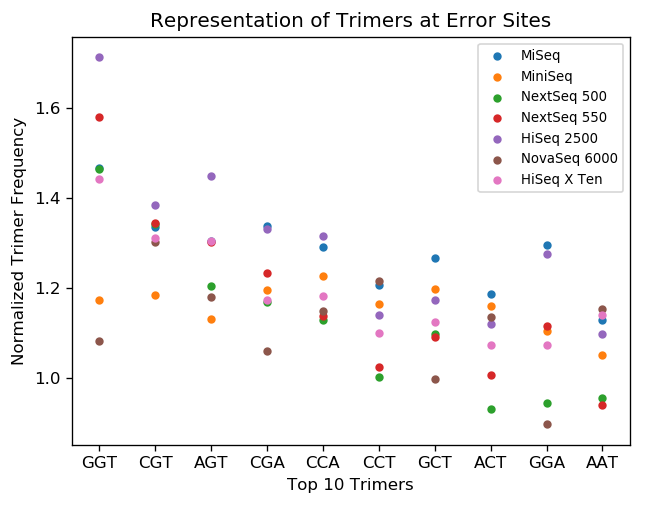

In [28]:
make_kmer_plot(kmers_by_model3, REF_KMERS, labels=MODELS)